# Collaboration and Competition

---

#### imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt
from IPython.display import Image

from unityagents import UnityEnvironment

from marl_coop.utils import Context, load_scores, Runner, plot_scores
from marl_coop.utils.loader import load_MADDPG_agent
from marl_coop.config import MADDPG_configuration
from marl_coop.agent import MADDPG_agents

In [2]:
path_images = r'./image'

__________
## Description of the environment

In this environment, **two agents control rackets to bounce a ball over a net**. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The **observation space** consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. **Two continuous actions are available**, corresponding to movement toward (or away from) the net, and jumping.

The **task is episodic**, and in order to solve the environment, the agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically, after each episode, the rewards that each agent received (without discounting) is added up, to get a score for each agent. This yields 2 (potentially different) scores, the maximum of these 2 scores is kept as a single score for each episode.

The environment is considered **solved**, when the average (over 100 episodes) of those scores is at least **+0.5**.

Image of the Unity environment tennis : 



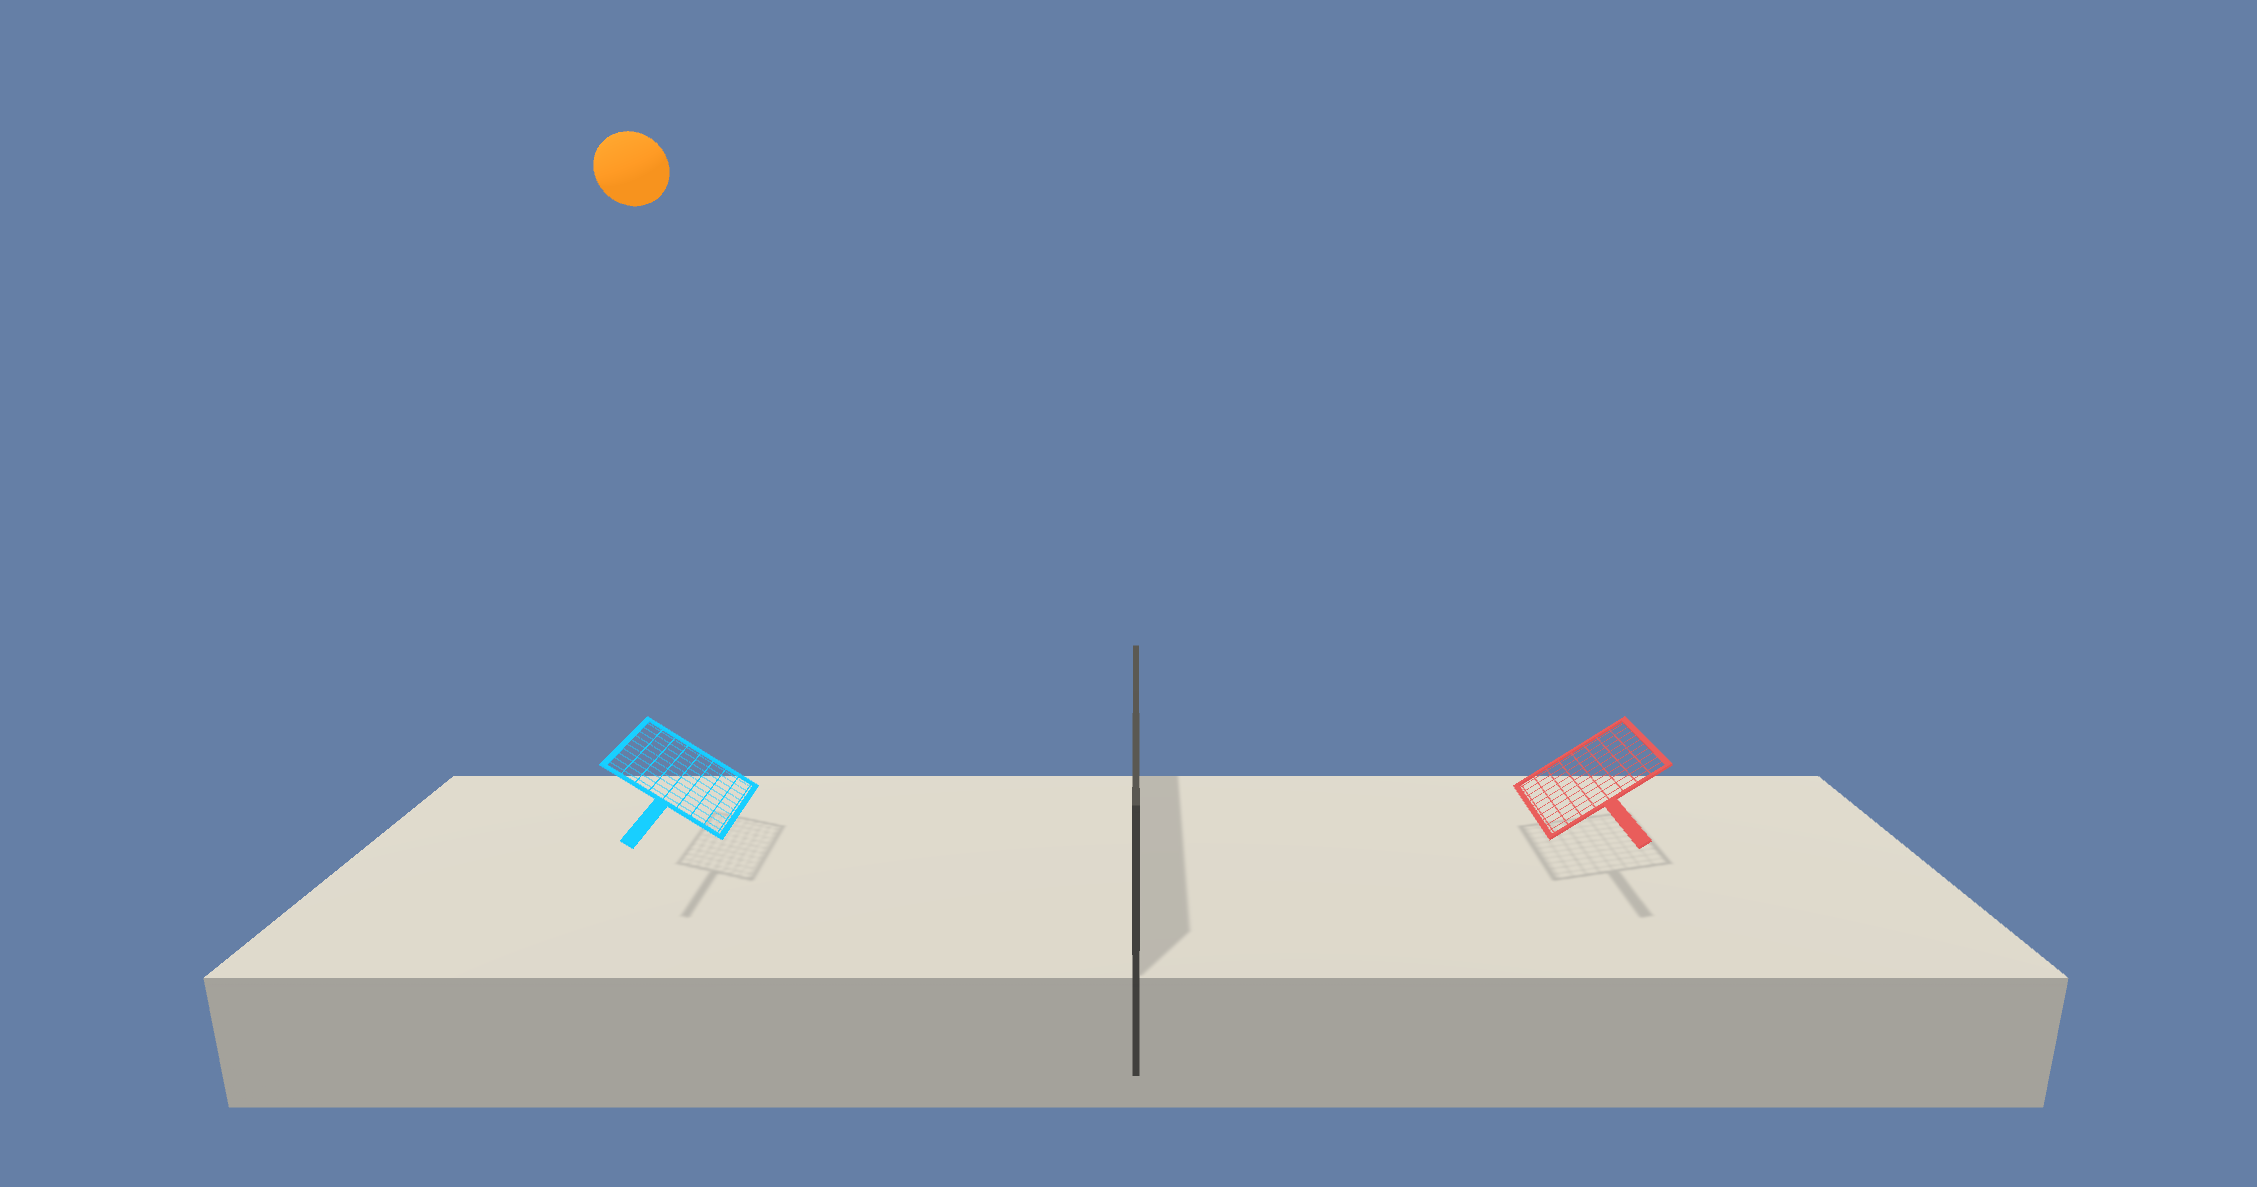

In [3]:
print('Image of the Unity environment tennis : \n')
Image(os.path.join(path_images, 'environment_tennis.png'), width = 600, height = 400) 

## Training

#### Start the environment and describe the task

In [4]:
file_name = ('C:/Users/pierr/Desktop/DataScience/Formation/2020_Udacity_DeepRL'
             +'/deep-reinforcement-learning/Unity_environments/'
             +'Tennis_Windows_x86_64/Tennis.exe')
file_name = r'../../Unity_environments/Tennis_Windows_x86_64/Tennis.exe'
env = UnityEnvironment(file_name=file_name)


brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# Description of the environment
nbr_agents = len(env_info.agents)
print('Number of agents:', nbr_agents)

action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

runner = Runner()
nbr_agents = len(env_info.agents)
ctx = Context(brain, {'nbr_agents': nbr_agents, 'action_min': -1,  'action_max': 1})

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
%%time

agent_cfg = {
    'seed':1,
    'gamma':.98,
    'tau':1e-3,
    'update_every': 20,
    'learing_per_update': 5,
    'use_gradient_clipping': .9,
    'critic':{
        'criterion': 'SmoothL1',
        'hidden_layers': [64, 64],
        'learning_rate': 3e-4
    },
    'actor':{
        'hidden_layers': [64, 64],
        'learning_rate': 8e-5
    },
    'buffer':{
        'type': 'prioritized_sumTree',
        'size': 100_000,
        'batch_size': 512,
        'alpha': .8,
        'beta': .5,
        'epsilon':.005,
        'sample_with_replacement': False
    },
    'noise':{
        'method': 'scaling_OU',
        'theta': .1,
        'theta_max': .3,
        'theta_nbr_growths': 80_000,
        'sigma': 1,
        'sigma_min': .07,
        'sigma_nbr_decays': 80_000
    }
}
agents_config={
    'agent_1': agent_cfg,
    'agent_2': agent_cfg
}

cfg = MADDPG_configuration(nbr_agents=nbr_agents, agents_config=agents_config)
maddpg = MADDPG_agents(ctx, cfg)

Wall time: 965 ms


#### Watch the agent interact for one episode

In [6]:
%%time

env_info = env.reset(train_mode=False)[brain_name]    
observations = env_info.vector_observations           
scores = np.zeros(nbr_agents)                         

while True:
    
    actions = maddpg.act(observations, noise=True)
    
    env_info = env.step(actions)[brain_name]        
    next_observations = env_info.vector_observations
    rewards = env_info.rewards                      
    dones = env_info.local_done                     
    scores += env_info.rewards                      
    
    maddpg.step(observations, actions, rewards, next_observations, dones)
    observations = next_observations                
    
    if np.any(dones):                               
        break

Wall time: 553 ms


#### Training the agents over 10 000 episodes.

In [7]:
key = 'tennis_cooperation'
nb_episodes = 8_000

runner.run(maddpg, env, brain_name, nb_episodes, key, target_score=.5,
               save_score=True, save_config=True, save_weights=True)

Noise scaling half life reached in 1229 episodes : OrnsteinUhlenbeckActionNoise(mu=0.0, sigma=0.535/0.07, theta=0.1295/0.3)
Noise scaling complete in 3802 episodes : OrnsteinUhlenbeckActionNoise(mu=0.0, sigma=0.07/0.07, theta=0.3/0.3)
Episode 8000 Score: 1.0515 -> Solved in 4359 episodes
Last score: 1.0515  -> Solved in 4359 episodes
 ... saving score ...
... saving actor ...
... saving critic ...
... saving actor ...
... saving critic ...


#### Observe its performances during training.

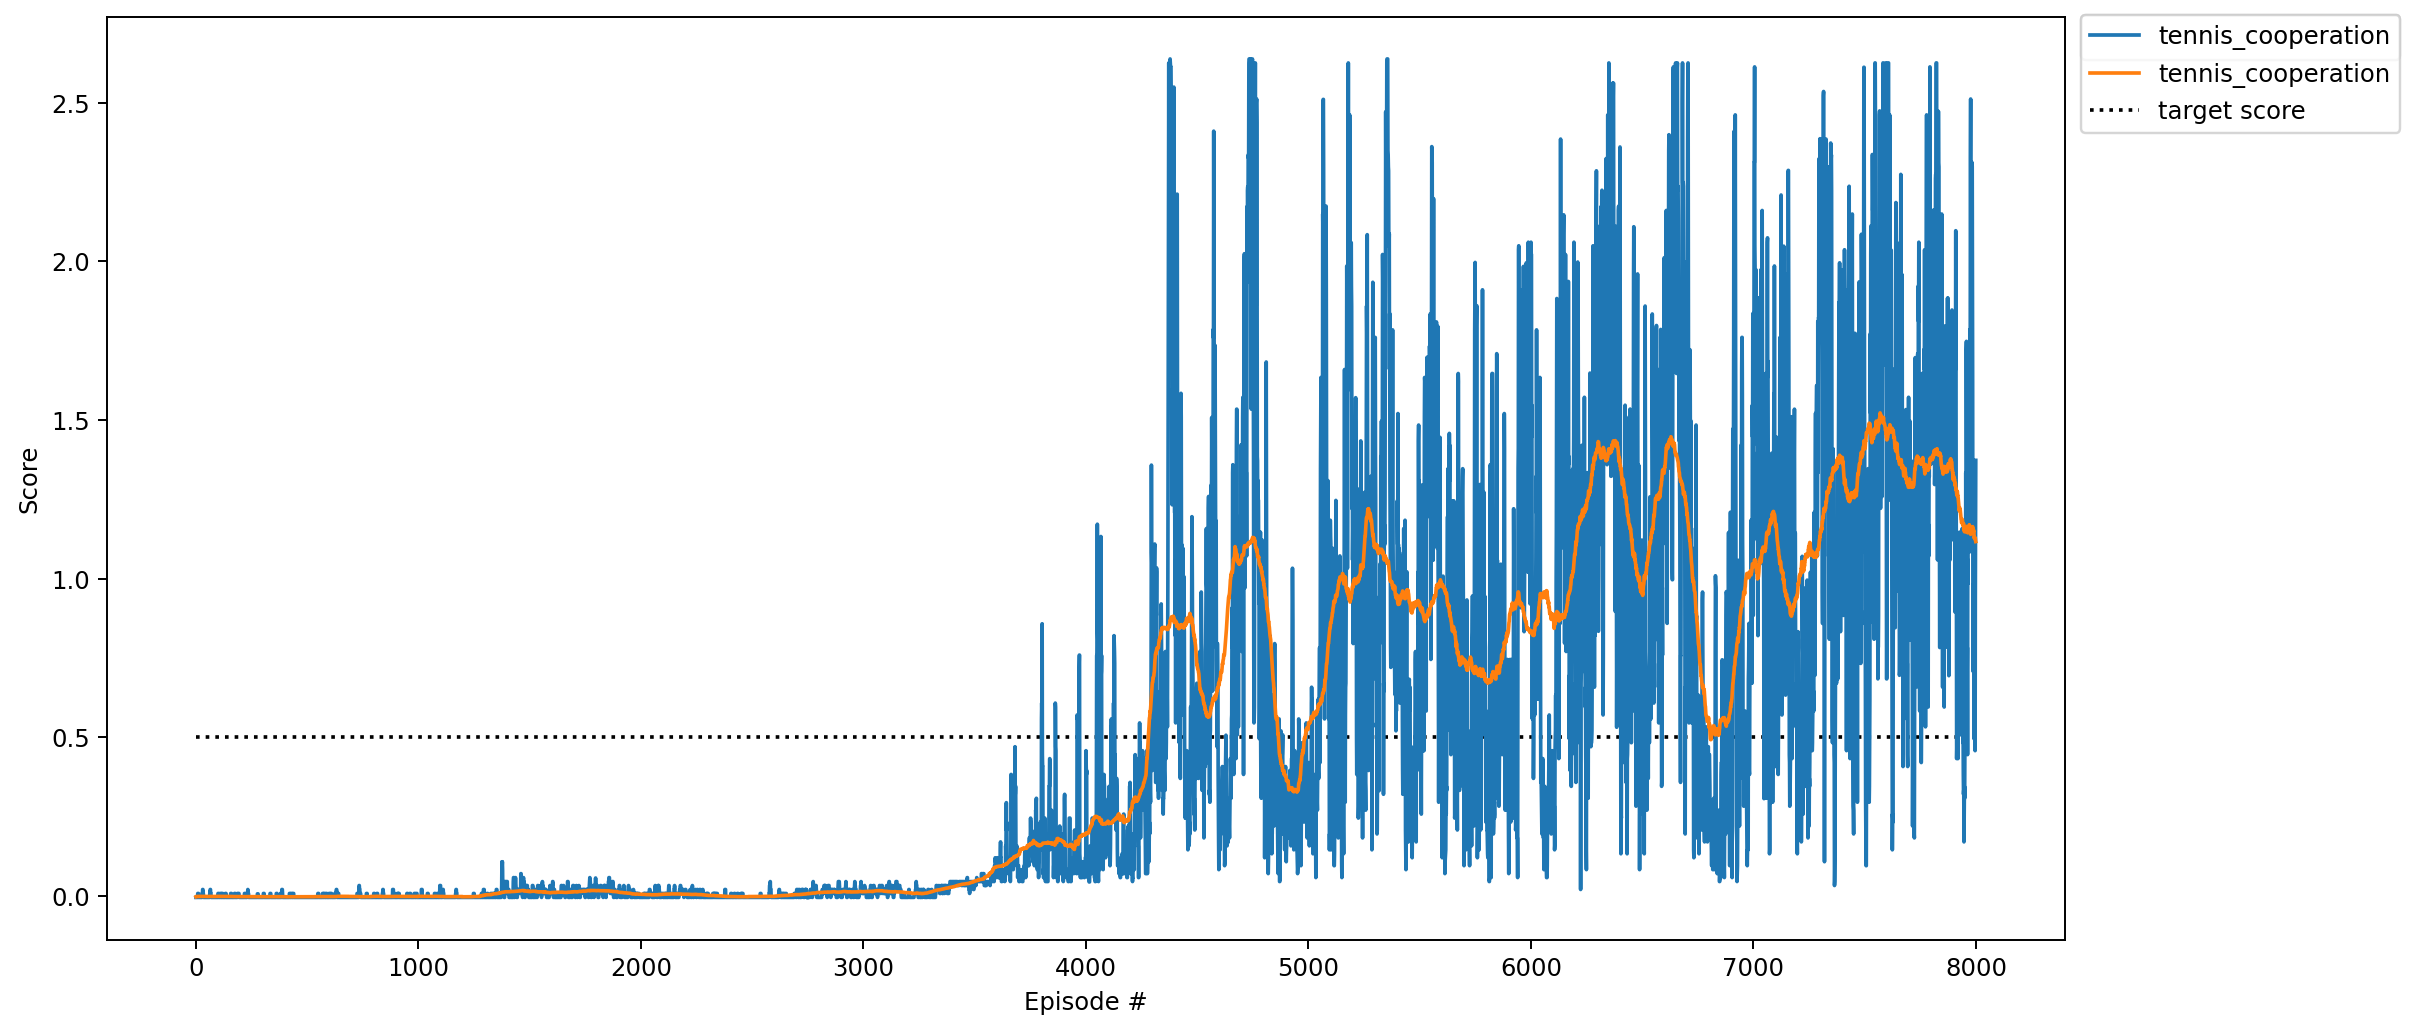

In [8]:
fig, axe = plt.subplots(1,1,figsize=(12,6), dpi=175)

plot_scores(load_scores(keys='tennis_cooperation'), window_size=5, axe=axe)
plot_scores(load_scores(keys='tennis_cooperation'), window_size=200, target_score=.5, axe=axe)

#### Load a trained agent and watch it interact for one episode

In [10]:
%%time

run_key = f'pre_trained'
maddpg = load_MADDPG_agent(run_key, ctx)

env_info = env.reset(train_mode=False)[brain_name]    
observations = env_info.vector_observations           
scores = np.zeros(nbr_agents)                         

while True:
    
    actions = maddpg.act(observations, noise=False)
    
    env_info = env.step(actions)[brain_name]        
    next_observations = env_info.vector_observations
    rewards = env_info.rewards                      
    dones = env_info.local_done                     
    scores += env_info.rewards                      
    
    observations = next_observations                
    
    if np.any(dones):                               
        break

print("Score: {}".format(np.max(scores)))

Score: 2.600000038743019
Wall time: 1min 41s


In [11]:
env.close()